\begin{equation}
 \frac {dy} {dt} + 0.1 y - sin(\pi*t/2) = 0, \\
 \end{equation}
 with initial condition y(0) = 1.


In [16]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

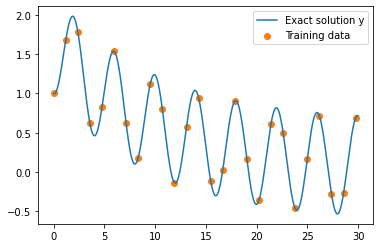

In [17]:
# Data Generator

def oscillatorb():
    nSteps=3000              # number of time steps .................
    tMin,tMax = 0.0,30.0      # Time domain ....................
    tStep = (tMax-tMin)/nSteps   # Time tep ....................
    tPoints = np.arange(tMin, tMax, tStep)
    
    # set initial conditions on the state variables ....................
    y0 = 1.0
    y = [y0]

    # solve for the time evolution
    for t in tPoints[1:]:
        tdemi= t - tStep/2.
        ydemi = y[-1] + tStep/2.*( - 0.1*y[-1] + np.sin(np.pi*tdemi/2))        
        y.append(y[-1] + tStep * (- 0.1*ydemi + np.sin(np.pi*t/2)))  
        
    y = torch.Tensor(y)
    # torch.Tensor(tPoints).size() -> torch.Size([3000])
    # torch.Tensor(tPoints).view(-1, 1).size() -> torch.Size([3000, 1])
    return torch.Tensor(tPoints).view(-1, 1), torch.Tensor(y).view(-1, 1)

x, y = oscillatorb()
x = x[::1] #[start:stop:step]
y = y[::1]

# Training Data는 119개만 뽑아냄
x_data=x[0:3000:119] #[start:stop:step]
y_data=y[0:3000:119]

plt.figure()
plt.plot(x, y, label= 'Exact solution y')
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()


# PINN

In [18]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

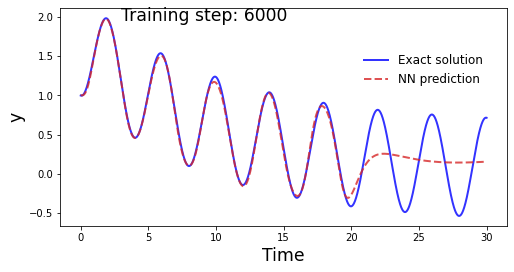

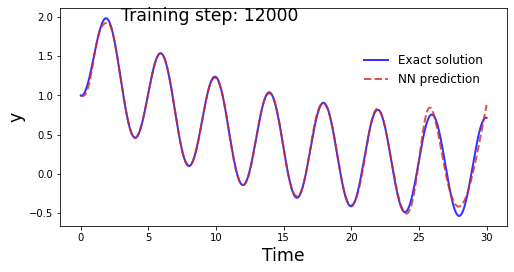

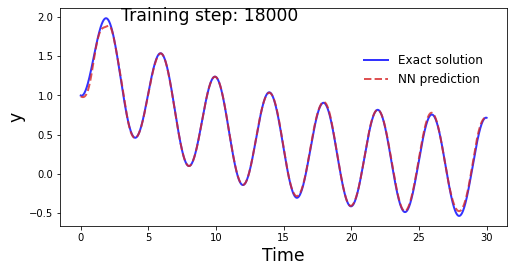

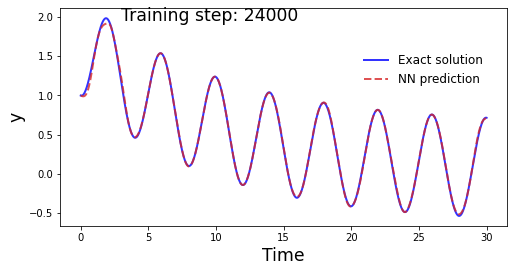

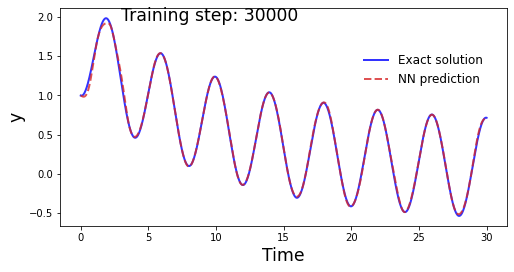

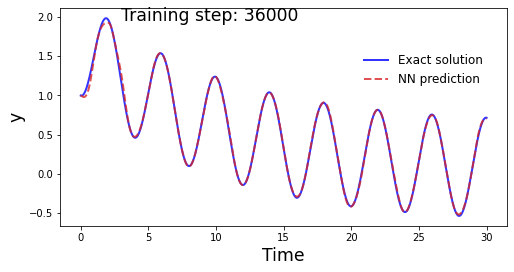

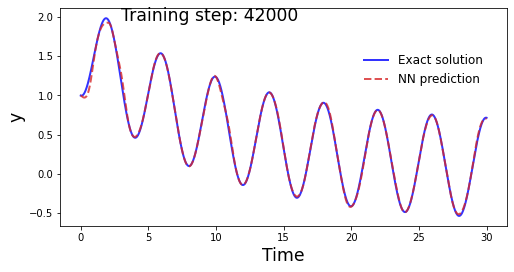

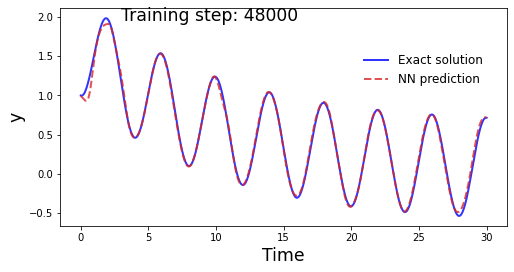

In [26]:
x_physics = torch.linspace(0,30,50).view(-1,1).requires_grad_(True)
# torch.linspace(0,30,50) -> torch.Size([50])
# torch.linspace(0,30,50).view(-1,1) -> torch.Size([50, 1])

lam = 0.1
torch.manual_seed(123)
model = FCN(N_INPUT=1,N_OUTPUT=1,N_HIDDEN=32,N_LAYERS=3)
optimizer = torch.optim.Adam(model.parameters(),lr=3e-3)

loss_history = []
loss2_history = []

for i in range(48000):
    optimizer.zero_grad()
    
    # We compute the "data loss" .............................................
    yh = model(x_data)
    loss1 = 1.*torch.mean((yh-y_data)**2)# use mean squared error
    
    yhp = model(x_physics)
    dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    
    physics = (dx + lam*yhp - torch.sin(np.pi*x_physics/2))
    loss2 = (6e-2)*(torch.mean(physics**2))
    
    loss = loss1 + loss2
    loss.backward()
    optimizer.step()
    
    if (i+1) % 100 ==0:
        loss_history.append(loss.detach())
        loss2_history.append(loss2.detach())
        
        yh = model(x).detach()
        xp = x_physics.detach()        
        
        plt.figure(figsize=(8,4))
        plt.plot(x,y, color="blue", linewidth=2, alpha=0.8,linestyle='-',label="Exact solution")
        plt.plot(x,yh, color="tab:red", linewidth=2, alpha=0.8, linestyle='--', label="NN prediction")
        
        # plot_result(x,y,x_data,y_data,yh,xp)
        l = plt.legend(loc=(0.67,0.62), frameon=False, fontsize="large")
        plt.setp(l.get_texts(), color="k")
        plt.ylabel('y',fontsize="xx-large")
        plt.xlabel('Time',fontsize="xx-large")
        plt.text(2.965,1.95,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
        plt.axis("on")
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
    
    